In [48]:
# !unzip ../Data/train_fixed.zip
# !unzip ../Data/test_fixed.zip
# !unzip ../Data/df.zip

Archive:  ../Data/df.zip
  inflating: df.csv                  


Import packages

In [56]:
# import warnings
# warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np


## Data preprocessing

In [70]:
df = pd.read_csv("df.csv", sep=";")

In [71]:
df = df[["id", "budget"]]

In [72]:
train = pd.read_csv("train.csv", sep=";").drop(columns="budget")
test = pd.read_csv("test.csv", sep=";").drop(columns="budget")

In [73]:
train = pd.merge(left=train, right=df, on="id")
test = pd.merge(left=test, right=df, on="id")

In [74]:
all_columns = train.columns.to_list()
label = ["vote_average"]
drop_columns = ["overview", "id", "overview_tokenized", "vote_label", "revenue",
                "popularity", "status", "vote_count", "Unnamed: 0", "year", "month", "day"]
ohe_columns = ["quarter", "k_means_cluster"]
num_columns = ["runtime", "budget"] + [f"lda_topic_{i}_proba" for i in range(15)]
resid_columns = list(set(all_columns) - set(label + drop_columns + ohe_columns + num_columns))


In [75]:
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

In [76]:
X_train, y_train = train.drop(columns="vote_average"), train["vote_average"]
X_test, y_test = test.drop(columns="vote_average"), test["vote_average"]

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first", min_frequency=4500, handle_unknown="infrequent_if_exist"))
    ]
)

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_columns),
        ("cat", categorical_transformer, ohe_columns),
    ],
    remainder="passthrough"
)

## Training functions

In [78]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def print_results(model_name, y_train, y_test, y_train_pred, y_test_pred) -> None:
    print(f"{model_name} results:")
    print("RMSE on train =", mean_squared_error(y_train, y_train_pred, squared=False))
    print("RMSE on test =", mean_squared_error(y_test, y_test_pred, squared=False))
    print()

    print("MAE on train =", mean_absolute_error(y_train, y_train_pred))
    print("MAE on test =", mean_absolute_error(y_test, y_test_pred))
    print()

    print("R^2 on train =", r2_score(y_train, y_train_pred))
    print("R^2 on test =", r2_score(y_test, y_test_pred))

In [79]:
def make_pipeline(model, *args, **kwargs):
    return Pipeline(
    steps=[("preprocessor", preprocessor), ("model", model(*args, **kwargs))]
)

In [80]:
from sklearn.model_selection import GridSearchCV
def evaluate_model(model, make_pipeline, X_train, y_train, X_test, y_test, param_grid=None, *args, **kwargs):
    if param_grid is None:
        pipe = make_pipeline(model, *args, **kwargs)
    else:
        pipe = GridSearchCV(make_pipeline(model, *args, **kwargs), param_grid=param_grid, scoring="neg_mean_squared_error")
    pipe.fit(X_train, y_train)

    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)
    
    print_results(model.__name__, y_train, y_test, y_train_pred, y_test_pred)
    return pipe

## Linear Models

In [81]:
from sklearn.linear_model import LassoCV
lasso = evaluate_model(LassoCV, make_pipeline, X_train, y_train, X_test, y_test, n_jobs=-1, random_state=59)

LassoCV results:
RMSE on train = 1.3171069953367673
RMSE on test = 1.145070402239908

MAE on train = 0.9983000935208411
MAE on test = 0.8813731269915086

R^2 on train = 0.13795701055179854
R^2 on test = 0.14839604065347622


In [82]:
from sklearn.linear_model import RidgeCV

ridge = evaluate_model(RidgeCV, make_pipeline, X_train, y_train, X_test, y_test)

RidgeCV results:
RMSE on train = 1.317072868404509
RMSE on test = 1.1450971131838494

MAE on train = 0.9981774283213235
MAE on test = 0.8813826062785125

R^2 on train = 0.13800168194399298
R^2 on test = 0.148356309627534


In [83]:
from sklearn.linear_model import ElasticNetCV

elastic_net = evaluate_model(ElasticNetCV, make_pipeline, X_train, y_train, X_test, y_test)

ElasticNetCV results:
RMSE on train = 1.3171255822073882
RMSE on test = 1.1450239602188486

MAE on train = 0.9983647380047518
MAE on test = 0.8813508705238429

R^2 on train = 0.13793268026636762
R^2 on test = 0.14846511833969345


## Random Forest

In [84]:
from sklearn.ensemble import RandomForestRegressor
random_forest = evaluate_model(RandomForestRegressor, make_pipeline, X_train, y_train, X_test, y_test, n_jobs=-1, random_state=59, max_depth=15)

RandomForestRegressor results:
RMSE on train = 1.1718104489539696
RMSE on test = 1.109893253605445

MAE on train = 0.8887026679507789
MAE on test = 0.8490489834920167

R^2 on train = 0.317658879815499
R^2 on test = 0.19991575826848984


Use PCA to speed up learning

In [85]:
from sklearn.decomposition import PCA
def make_pipeline_pca(model, *args, **kwargs):
    return Pipeline(
    steps=[("preprocessor", preprocessor), ("PCA", PCA(n_components=50, random_state=59)), ("model", model(*args, **kwargs))]
)

In [86]:
random_forest_pca = evaluate_model(RandomForestRegressor, make_pipeline_pca, X_train, y_train, X_test, y_test, n_jobs=-1, random_state=59, max_depth=15)

RandomForestRegressor results:
RMSE on train = 1.0815443376751115
RMSE on test = 1.1317764034793962

MAE on train = 0.8350852519001648
MAE on test = 0.8703030033992267

R^2 on train = 0.4187332679044361
R^2 on test = 0.16805510020518444


## Feature Importances

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")

### Random Forest

In [88]:
feaure_names = random_forest.named_steps["preprocessor"].get_feature_names_out()
importances = random_forest.named_steps["model"].feature_importances_
df_importances = pd.DataFrame({"feature": feaure_names, "importance": importances})
df_importances = df_importances.sort_values(by="importance", ascending=False)[:10]

/home/dangerio/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dangerio/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dangerio/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


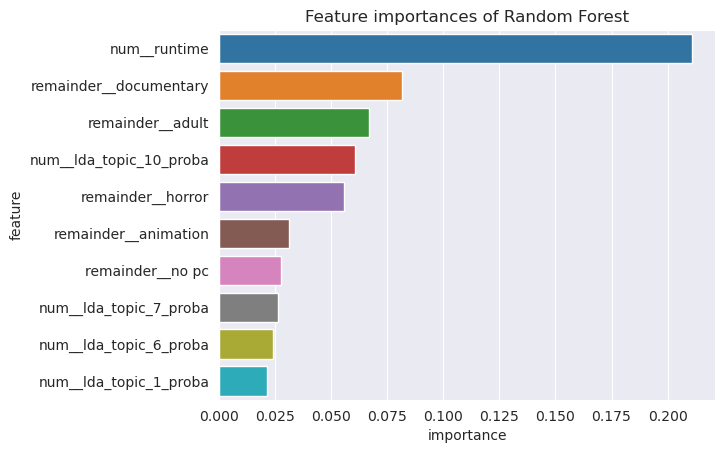

In [89]:
fig, ax = plt.subplots()
sns.barplot(data=df_importances, x="importance", y="feature", ax=ax)
ax.set_title("Feature importances of Random Forest");

### Lasso

In [90]:
feaure_names = lasso.named_steps["preprocessor"].get_feature_names_out()
importances = np.abs(lasso.named_steps["model"].coef_)
df_importances = pd.DataFrame({"feature": feaure_names, "absolute value of coef": importances})
df_importances = df_importances.sort_values(by="absolute value of coef", ascending=False)[:10]

/home/dangerio/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dangerio/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/dangerio/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


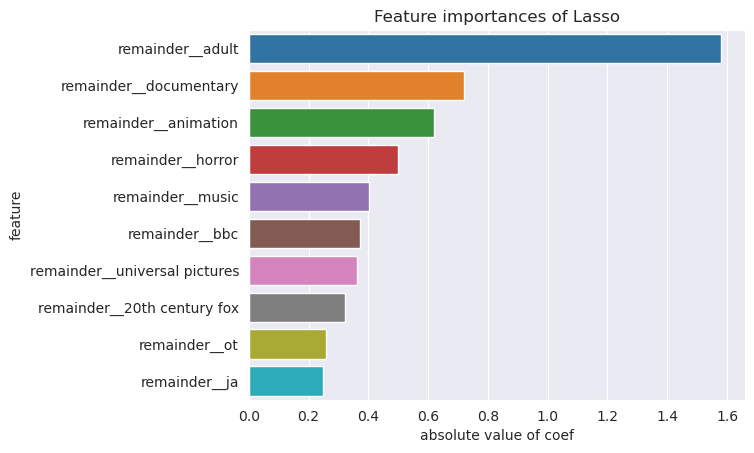

In [91]:
fig, ax = plt.subplots()
sns.barplot(data=df_importances, x="absolute value of coef", y="feature", ax=ax)
ax.set_title("Feature importances of Lasso");